In [1]:
import sys 
sys.path.append('../')
from dlim.model import DLIM 
from dlim.dataset import Data_model
from dlim.api import DLIM_API
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score
from numpy import mean
from numpy.random import choice
import pandas as pd
from tqdm import tqdm  
import matplotlib.pyplot as plt 
import numpy as np 
from matplotlib.patches import Patch

# Basic setting 

In [2]:
infile = "../data/elife/elife_data_subtle_env.csv"
# infile = "./data/elife/elife_data_strong_env.csv"
df_data = pd.read_csv(infile, sep = '@', header = None)
data = Data_model(data=df_data, n_variables=2)
if infile == "./data/elife/elife_data_strong_env.csv":
    model_save_path = "./pretrain_models/model_elife_strong.pth"
else:
    model_save_path = "./pretrain_models/model_elife_subtle.pth"

In [3]:
colors = [
    "#1f77b4",  # Blue
    "#ff7f0e",  # Orange
    "#2ca02c",  # Green
    "#d62728",  # Red
    "#9467bd",  # Purple
    "#8c564b",  # Brown
    "#e377c2",  # Pink
    "#7f7f7f",  # Gray
    "#bcbd22",  # Olive
    "#17becf",  # Cyan
    "#aec7e8"   # Light Blue
]

# get the environments
if infile == "./data/elife/elife_data_strong_env.csv":
    ENV_LIST = ['22 hr Ferm_fitness', '1 Day_fitness', '3 Day_fitness',
                '4 Day_fitness', '5 Day_fitness', '6 Day_fitness', '7 Day_fitness',
                'Baffle, 1.8% Gluc_fitness', 'Baffle, 2.5% Gluc_fitness',
                'Baffle, 0.4 μg/ml Ben_fitness', 'Baffle, 2 μg/ml Ben_fitness',
                '0.2 M NaCl_fitness', '0.5 M NaCl_fitness', '0.2 M KCl_fitness',
                '0.5 M KCl_fitness', '8.5 μM GdA (B9)_fitness',
                '17 μM GdA_fitness', '0.5 μg/ml Flu_fitness', '1% EtOH_fitness',
                '1.5% Suc, 1% Raf_fitness']
    ENV_SHORT_LIST = ['Ferm', 'Transfer Day', 'Transfer Day',
                      'Transfer Day','Transfer Day', 'Transfer Day', 'Transfer Day',
                      'Gluc', 'Gluc',
                      'Ben', 'Ben',
                      'NaCl', 'NaCl', 'KCl',
                      'KCl', '8.5 μM GdA (B9)_fitness',
                      '17 μM GdA_fitness', '0.5 μg/ml Flu_fitness', '1% EtOH_fitness',
                      '1.5% Suc, 1% Raf_fitness']
else:
    ENV_LIST = ['EC Batch 19_fitness', 'EC Batch 3_fitness', 'EC Batch 6_fitness',
                'EC Batch 13_fitness', 'EC Batch 18_fitness',
                'EC Batch 20_fitness', 'EC Batch 21_fitness',
                'EC Batch 23_fitness', 'EC 1BigBatch_fitness',
                '12 hr Ferm_fitness', '8 hr Ferm_fitness', '18 hr Ferm_fitness',
                '0.5% DMSO_fitness', '8.5 μM GdA (B1)_fitness',
                'Baffle, 1.4% Gluc_fitness', 'Baffle (B8)_fitness',
                'Baffle, 1.6% Gluc_fitness', 'Baffle, 1.7% Gluc_fitness',
                'Baffle (B9)_fitness', '1.4% Gluc_fitness', '1.8% Gluc_fitness',
                '2 μg/ml Flu_fitness', '1% Raf_fitness', '0.5% Raf_fitness',
                '1% Gly_fitness']
    ENV_SHORT_LIST = ['EC', 'EC', 'EC', 'EC',
                      'EC', 'EC', 'EC', 'EC',
                      'EC', 'Ferm', 'Ferm', 'Ferm',
                      '0.5% DMSO', '8.5 μM GdA (B1)', 'Gluc', 'Baffle',
                      'Gluc', 'Gluc', 'Baffle',
                      'Gluc', 'Gluc', '2 μg/ml Flu', 'Raf', 'Raf',
                      '1% Gly']
uni_env_short = {env: i for i, env in enumerate(list(set(ENV_SHORT_LIST)))}
conv_env = {env: env_s for env, env_s in zip(ENV_LIST, ENV_SHORT_LIST)}
inv_mut_env = {i: env for env, i in data.substitutions_tokens[1].items()}


# get the mutation types
mutation_types = ['CYR1', 'Diploid', 'Diploid + Chr11Amp', 'Diploid + Chr12Amp',
                  'Diploid + IRA1', 'Diploid + IRA2', 'Diploid_adaptive', 'ExpNeutral', 'GPB1',
                  'GPB2', 'IRA1_missense', 'IRA1_nonsense', 'IRA1_other', 'IRA2', 'KOG1',
                  'NotSequenced', 'NotSequenced_adaptive', 'PDE2', 'RAS2', 'SCH9', 'TFS1', 'TOR1',
                  'other', 'other_adaptive']

mut_type_col = {name: i for i, name in enumerate(mutation_types)}
inv_mut_type = {i: env for env, i in data.substitutions_tokens[0].items()}

In [4]:
data = Data_model(data=df_data, n_variables=2)

model = DLIM(n_variables = data.nb_val, hid_dim = 64, nb_layer = 1)
dlim_regressor = DLIM_API(model=model, flag_spectral=True, load_model= None)
losses = dlim_regressor.fit(data, lr = 1e-3, weight_decay=1e-3, nb_epoch=200, batch_size=128, emb_regularization=1e-2, save_path=model_save_path)

fit, var, lat  = dlim_regressor.predict(data.data[:,:-1], detach=True) 
score = r2_score(fit.flatten(), data.data[:, [-1]].flatten())
print(score) 

spectral gap = 0.7541811466217041
spectral gap = 0.9451983571052551
Model saved to ./pretrain_models/model_elife_subtle.pth
0.8895338535230077


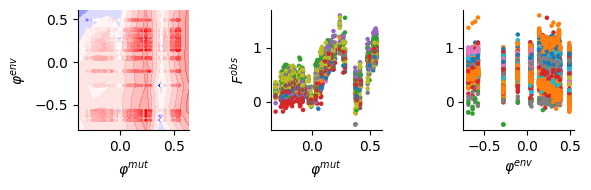

In [7]:
model = DLIM(n_variables = data.nb_val, hid_dim = 64, nb_layer = 1)
dlim_regressor = DLIM_API(model=model, flag_spectral=True, load_model= model_save_path)
fig, (bx, cx, dx) = plt.subplots(1, 3, figsize=(6, 2))
dlim_regressor.plot(bx, data, fontsize= 10)
bx.set_xlabel("$\\varphi^{mut}$")
bx.set_ylabel("$\\varphi^{env}$")

for xx in [bx, cx, dx]:
    for el in ["top", "right"]:
        xx.spines[el].set_visible(False)



dat = pd.read_csv("../data/elife/elife-61271-fig2-data1-v2.csv")
conv_bar_mut = {}
for i, row in dat.iterrows():
    if row['barcode'] not in conv_bar_mut:
        conv_bar_mut[row['barcode']] = row['mutation_type']
    else:
        assert conv_bar_mut[row['barcode']] == row['mutation_type']

sel_env = ["KCl", "NaCl"]
legend_elements = [Patch(facecolor=colors[i], edgecolor='none', label=name) for name, i in uni_env_short.items() if name in sel_env]
# legend_elements = [Patch(facecolor=colors[i], edgecolor='none', label=name) for name, i in uni_env_short.items()]
cx.legend(handles=legend_elements, loc='lower left', fontsize=8, frameon=False)

cx.scatter(lat[:, 0], data[:, -1], s=5, c=[colors[uni_env_short[conv_env[inv_mut_env[int(i)]]]] for i in data[:, 1]])
dx.scatter(lat[:, 1], data[:, -1], s=5, c=["C"+str(mut_type_col[conv_bar_mut[inv_mut_type[i]]]) for i in data[:, 0].int().numpy()])
cx.set_ylabel("$F^{obs}$")
cx.set_xlabel("$\\varphi^{mut}$")
dx.set_xlabel("$\\varphi^{env}$")
plt.tight_layout()
# plt.savefig("./img/spec_elife_strong.png", dpi=300, transparent=True)
plt.show()

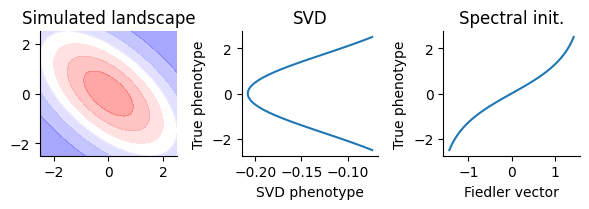

In [6]:
from numpy import linspace, arange, meshgrid, array, exp, sin, concatenate, cos
from numpy import pi as npi, power, diag, allclose
from numpy.linalg import det, svd, eig
from numpy.random import normal, uniform
import numpy as np
import matplotlib.pyplot as plt

def rotated_gaussian_mesh(X, Y, alpha=45, center=[2.5, 2.5]):
    a = (3.14/180) * alpha
    m11 = cos(a)**2 / 2 + 2 * sin(a)**2
    m12_m21 = -sin(2*a) / 4 + sin(2*a)
    m22 = sin(a)**2 / 2 + 2 * cos(a)**2
    M = array([[m11, m12_m21],
               [m12_m21, m22]])
    det_M = det(M)
    X = X - center[0]
    Y = Y - center[0]

    F = exp(-((X**2 * M[0,0] + 2 * X * Y * M[0,1] + Y**2 * M[1,1]) / (2 * npi * det_M)))
    return F

nb_var = 40
A = linspace(-2.5, 2.5, 40)
B = linspace(-2.5, 2.5, 40)
p1, p2 = meshgrid(A, B)
land = rotated_gaussian_mesh(p1, p2, center=[0, 0])


# # land = p1 + p2

u, s, vh = svd(land, full_matrices=True)

recons = (u[:, :s.shape[0]] @ diag(s)) @ vh
allclose(recons, land)

fig, ax = plt.subplots(1, 3, figsize=(6, 2.2))

ax[0].contourf(p1, p2, land, cmap="bwr", alpha=0.4)
ax[0].set_title("Simulated landscape")

ax[1].plot(u[:, 0], B)
# ax[1].scatter(vh[0, :], A)
ax[1].set_title("SVD")
ax[1].set_xlabel("SVD phenotype")
ax[1].set_ylabel("True phenotype")

def cosine_similarity_matrix(A, pearson=False):
    if pearson:
        A = A - A.mean(axis=1, keepdims=True)
    # Step 1: Compute the dot product between all pairs of rows
    dot_product = np.dot(A, A.T)  # Shape: (N, N)
    # Step 2: Compute the L2 norms of each row
    norms = np.linalg.norm(A, axis=1)  # Shape: (N,)
    # Step 3: Compute the outer product of the norms
    norm_matrix = np.outer(norms, norms)  # Shape: (N, N)
    # Step 4: Compute the cosine similarity matrix
    cosine_similarity = dot_product / norm_matrix  # Element-wise division
    return cosine_similarity + 1

pearson = True
A_d = cosine_similarity_matrix(land, pearson=pearson)
D_is = np.diag(1.0 / np.sqrt(A_d.sum(axis=1)))
L_aa = np.eye(A_d.shape[0]) - D_is @ A_d @ D_is

A_d = cosine_similarity_matrix(land.T, pearson=pearson)
D_is = np.diag(1.0 / np.sqrt(A_d.sum(axis=1)))
L_bb = np.eye(A_d.shape[0]) - D_is @ A_d @ D_is

eiv_aa, eig_aa = eig(L_aa)
eiv_bb, eig_bb = eig(L_bb)
fid_aa = (eig_aa[:, 1] - eig_aa[:, -1].mean())/eig_aa[:, -1].std()
fid_bb = (eig_bb[:, 1] - eig_bb[:, -1].mean())/eig_bb[:, -1].std()


ax[2].plot(fid_aa.flatten(), B.flatten())
# ax[2].scatter(fid_bb.flatten(), A.flatten())
ax[2].set_title("Spectral init.")
ax[2].set_xlabel("Fiedler vector")
ax[2].set_ylabel("True phenotype")

for i in range(3):
    for el in ["top", "right"]:
        ax[i].spines[el].set_visible(False)

plt.tight_layout()
# plt.savefig("./img/spec_laplacian_vs_svd.png", dpi=300, transparent=True)
plt.show()